* [Метрики](#метрики)
* [Разбор аномалий и закономерностей](#аномалий)
   * [Разбор таблицы orders](#orders)
       * [Разбор аномалий по сумме доставки](#доставки)
       * [Разбор аномалий по колиечству товара](#количество)
       * [Разбор аномалий по  среднему чеку](#чеку)
       * [Чистка данных](#Чистка)
       * [Среднее количествo покупателей](#покупателей) 
       * [Средний чек](#Срчек) 
       * [Средний вес](#вес)
       * [Среднее количество товаров](#количествотоваров)
       * [Средняя сумма доставки](#суммадоставки)
       * [Разбор отмененных доставок](#отмененных)
   * [Разбор таблицы replacements](#replacements)
       * [Среднее количество замен](#замен) 
   * [Разбор таблицы cancellations](#cancellations)
       * [Среднее количество отмен](#отмен) 
   * [Разбор таблицы delivery_windows](#delivery_windows)
       * [Время одидания доставки](#ожидания) 
* [Вывод](#вывод) 

# Метрики <a id="метрики"></a> 

Исходя из специфики индустрии и бизнес-модели СберМаркета, я бы отразила данные метрики:

1. Метрики покупок DAU, WAU и MAU, чтобы понимать, в какое время дня, недели и месяца клиент покупает наибольшее количество товаров. Также актуально для распознования сезонной изменчивости, такой как Новогодние праздники, Черная пятница в ноябре и далее. Зная эту данные, можно предложить клиенту более актуальную рекламу или скидку.

2. Одной из самых важных метрик можно считать средний чек за период или сезон. Понимая, сколько приносит каждый заказ, можно корректировать свою стратегию развития. Опираясь на значения трафика и конверсии, размер среднего чека позволяет прогнозировать выручку интернет-магазина.

3. Метрика Отмен и Замен. Важно изучать, какую операцию с товаром, которого не оказлось в магазине, предпочитает клиент (заменять или отменять) и процент замененных товаров относительно отмененных заказов. Можно предположить, что если у нас намного больше отмен, чем замен, то покупателю могут плохо предоставлять опции замены или не дожидаться ответа клиента на звонок по поводу замены (позвонить в неподходящее время)

4. 
    1. Имея данные за почти полтора года (а это наш нынешний фрейм), мы можем разделить наших покупателей на когорты и наблюдать за совокупной ценностью клиента за опреденный период. Когорты могут быть, например, такими: кто заказал один раз, кто сделал больше среднего количкства заказов и так далее. Важно считать ценность не всех клиентов сразу, а конкретной группы — так эффект от изменений получается более наглядными. 

    2. Так же в дальшнейшем можно привязать данные знания о клиентах к локациям и посмотреть, какой машазин "проседает" относительно других и начать выялвлять причину - все это можно связать с затратами на рекламу и смотреть на соотношение, когда наши точки выходят в плюс и выходит ли. 

5. Важно отметить, какое впечатление производит на покупателя доставщик, поскольку он - единтсвенное лицо, которое встречает покупатель за все время работы с приложением. В данном фрейме нет, но веротяно в целом имеется система оценки курьера, по которой можно судить в каких районах/городах курьеры наименее приятны покупателю и понять почему. 

# Разбор аномалий и закономерностей <a id="аномалий"></a> 

In [1]:
import psycopg2
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import numpy as np
import pylab as pl

In [2]:

#import plotly_express as px

pd.set_option('max_rows', 12)

conn = psycopg2.connect(
            host='rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net',
            port=6432,
            dbname='hr-analytics',
            sslmode='require',
            user='analytics',
            password='HRanalytics')

cur = conn.cursor()

##  Разбор таблицы orders <a id="orders"></a> 

In [3]:
df = pd.read_sql_query('''SELECT * FROM orders''', conn)
df['created_at_year'] = pd.DatetimeIndex(df['created_at']).year
df['created_at_month'] = pd.DatetimeIndex(df['created_at']).month
df['created_at_month_year'] = pd.to_datetime(df['created_at']).dt.to_period('M')
display(df.head())
df = df.drop_duplicates()
df.shape

id  user_id  total_cost   cost  item_total  promo_total  total_weight  \
0  756927   139676         0.0    0.0        5015          0.0         37708   
1  756963   139682         0.0    0.0        7096          0.0         49435   
2  756983    63967       299.0  299.0        2724       -250.0         11590   
3  756985   139687         0.0    0.0        3471          0.0          9915   
4  757066   119006       299.0  299.0        1254          0.0         15022   

   total_quantity    state          shipped_at          created_at  \
0              39  shipped 2018-08-26 15:01:42 2018-08-26 02:06:55   
1              71  shipped 2018-08-26 16:28:41 2018-08-26 05:43:20   
2              32  shipped 2018-08-26 15:09:11 2018-08-26 06:12:13   
3              13  shipped 2018-08-26 18:57:01 2018-08-26 06:13:59   
4              24  shipped 2018-08-26 13:46:48 2018-08-26 07:40:58   

   ship_address_id  store_id  delivery_window_id  created_at_year  \
0           888330         1              226459             2018   
1           888394         1              226460             2018   
2           888420         1              226459             2018   
3           888422         1              226462             2018   
4           870688         1              226458             2018   

   created_at_month created_at_month_year  
0                 8               2018-08  
1                 8               2018-08  
2                 8               2018-08  
3                 8               2018-08  
4                 8               2018-08

(720433, 17)

In [4]:
print(df.created_at.min())
print(df.created_at.max())
print()
print(df.shipped_at.min())
print(df.shipped_at.max())

#Наш датафрейм катируется датами с 26 августа 2018-го по 18 декаьря 2019. Почти полтора года. 

2018-08-26 00:05:41
2019-12-18 18:02:41

2018-08-26 07:46:10
2019-12-18 23:47:42


In [5]:
df_describe = df.loc[:,['total_cost', 'cost', 'item_total','total_quantity' ]].describe(percentiles = [.75, .9, .99])
df_describe

total_cost           cost     item_total  total_quantity
count  720433.000000  720433.000000  720433.000000   720433.000000
mean      171.820556     252.459416    4936.180057       42.923062
std       152.639804     144.192244    4801.748586       79.485753
min      -148.000000       0.000000       0.000000        0.000000
50%       158.000000     249.000000    3964.000000       32.000000
75%       263.000000     299.000000    5918.000000       50.000000
90%       304.000000     344.000000    8744.000000       77.000000
99%       609.000000     695.000000   19564.680000      202.000000
max     30000.000000   30000.000000  481195.000000    36040.000000

Сделаем выборку по чилсенным данным и посмотрим, какие аномалии у нас имеются. 
- По таблице видно, что в графах total_cost и cost значения сильно похожи, но следует заметить, что минимальное начение для total_cost уходит в минус - значит, кто-то "заработал" на скидке. В то же время минимальая цена вданном случае - 0. Максимум ля них обоих - 30.000 рублей за доставку (что характерно только для 1%, для 99: характерны доставки до 700 рублей).
- Графа item_total(средний чек)также имеет аномалии - для 90% харктерен средний чек на 8750 рублей и меньше, для оставшихся 10% - почти 20 тыс рублей и для 1% - от 20 тыс рублей до 481.195 тыс рублей (почти полмиллиона рублей!).
- Графа total_quantity(Количество единиц товара) варьирует в среднем до 200 товаров для 99% покупателей. Только для 1% характерно покупать на свыше, чем 200 товаров и доходит до своего максимума в 36 тыс единиц товара, купленного за раз.

Я бы хотела посмотреть поближе на тех, кто "заработал" на доставке, на ех, кто купил товаров на полмиллиона рублей и тех. кто заказ 36 тыс единиц товара. 

In [6]:
def graph(item):
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.scatter(range(df.shape[0]), df[item].values, alpha = .2)
    plt.title(item)
    plt.xlabel(item)
    plt.ylabel("Clients Amount");
    plt.show()

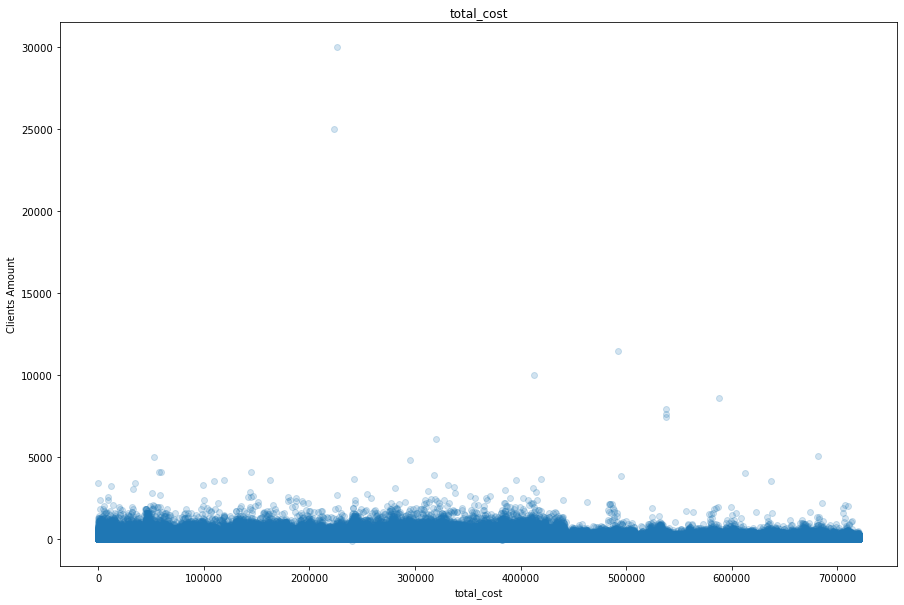

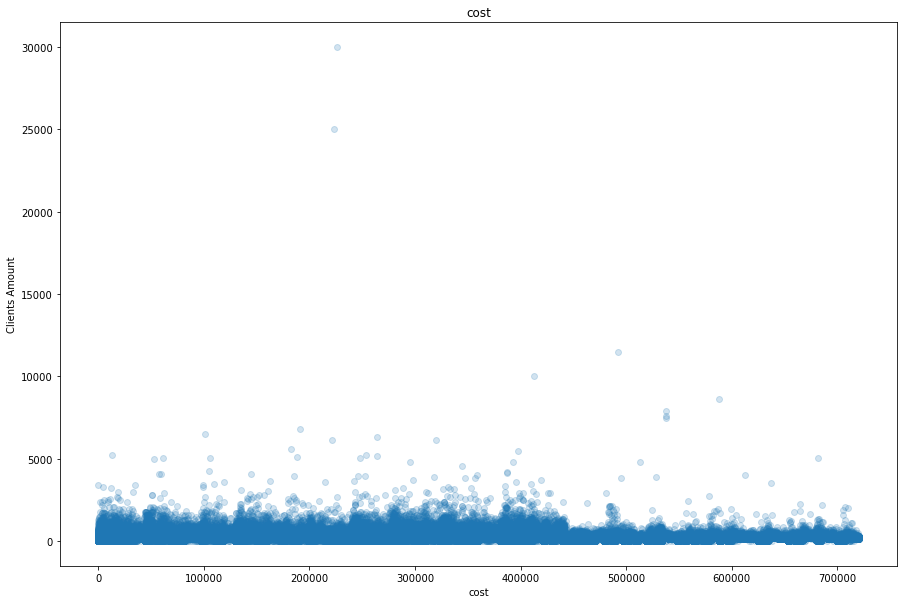

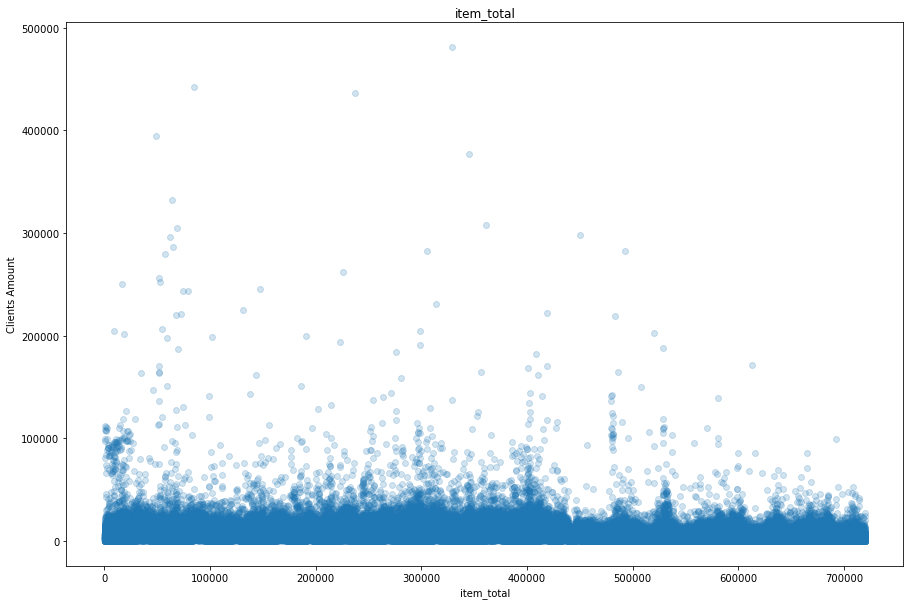

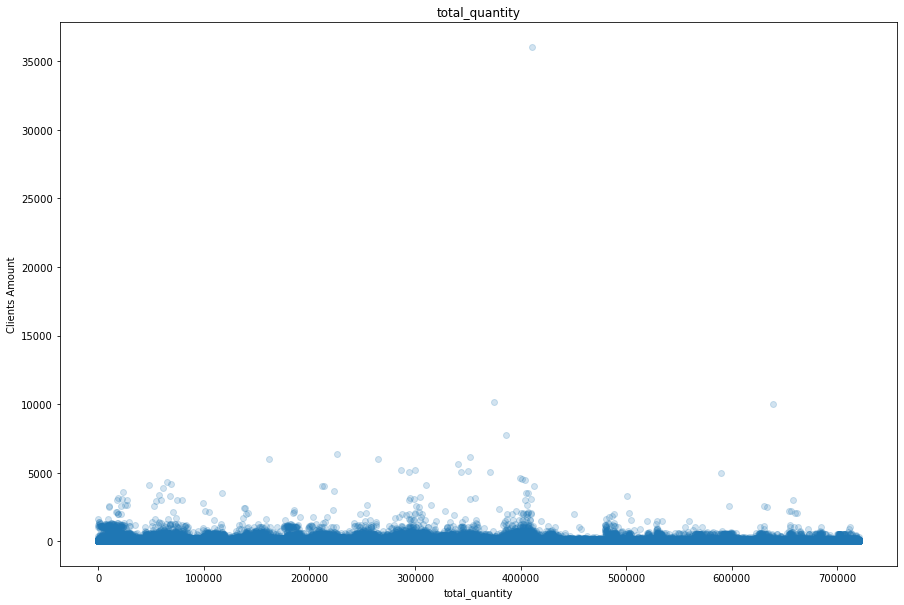

In [7]:
for item in df_describe:
    graph(item)

Визуализировав данне, четко видим, что есть буквально десяти покупателей, чья доставка обошлась им в больше, чем в 5 тыс рублей до и после скидки. Есть ровно один покупатель, который купил на свыше, чем на 35 тыс единиц товара, 2 покупателя взяли 10 тыс единиц товара и остальные остались за пределами 10 тыс товара (большинство за пределами 1000). В графе "средний чек" данные разбросаны намного сильнее, чем в других строках - но все ще не свыше 30-и человек заказали на больше, чем 200 тыс рублей, большинство колеблется на сумме до 100 тысяч. 

- Разбор аномалий по сумме доставки <a id="доставки"></a> 

In [8]:
df[df.total_cost < 0].sort_values(by = 'total_cost')

id  user_id  total_cost   cost  item_total  promo_total  \
240505  802572    60247      -148.0  299.0        5615          0.0   
381924  795110     4585       -99.0  497.0        3424          0.0   
382148  802465    19214       -99.0  299.0        2139          0.0   

        total_weight  total_quantity    state          shipped_at  \
240505         35357              43  shipped 2018-09-20 14:36:11   
381924         17877              64  shipped 2018-10-10 17:31:12   
382148         35228              31  shipped 2018-09-20 12:11:22   

                created_at  ship_address_id  store_id  delivery_window_id  \
240505 2018-09-19 04:12:17           274349        11              247485   
381924 2018-09-15 12:18:13           940822        21              264264   
382148 2018-09-18 22:45:05           858935        21              247582   

        created_at_year  created_at_month created_at_month_year  
240505             2018                 9               2018-09  
381924             2018                 9               2018-09  
382148             2018                 9               2018-09

Видим, что некотрые клиенты "заработали" на скидке. Финальная стоимость доставки выходит ниже нуля для трех случаев. Это может быть связано с ошибкой в системе.

- Разбор аномалий по колиечству товара <a id="количество"></a> 

In [9]:
total_quantity_99 = df[df.total_quantity > np.percentile(df.total_quantity,99.9)]
#df  у которого в списке только покупатели, купившие крупное количество едениц товара

print('Минимум покупок для 0.1% покупателей: ', total_quantity_99.total_quantity.min())
display(total_quantity_99.groupby('user_id').agg(quantity_count=('total_quantity', 'count'),
                                         quantity_mean=('total_quantity', 'mean')).sort_values(by = 'quantity_count',
                                                                                              ascending = False).head())
print(total_quantity_99.shape)

Минимум покупок для 0.1% покупателей:  716


quantity_count  quantity_mean
user_id                               
32490                92    1117.847826
31050                41    1123.024390
314205               22    1661.909091
165626               21     999.571429
171371               16    2573.312500

(721, 17)


In [10]:
total_quantity_99.groupby('user_id').agg(quantity_count=('total_quantity', 'count'),
                                         quantity_mean=('total_quantity', 'mean')).sort_values(by = 'quantity_mean',
                                                                                              ascending = False).head()

quantity_count  quantity_mean
user_id                               
1059879               1        36040.0
1568274               1        10000.0
229708                1         6124.0
1207271               1         6000.0
169427                1         6000.0

In [11]:
df[df.user_id == 1059879]

id  user_id  total_cost   cost  item_total  promo_total  \
410838  2755501  1059879         0.0  846.0       25708          0.0   

        total_weight  total_quantity    state          shipped_at  \
410838        200000           36040  shipped 2019-10-18 09:02:36   

                created_at  ship_address_id  store_id  delivery_window_id  \
410838 2019-10-15 06:49:57          3977452        21              791510   

        created_at_year  created_at_month created_at_month_year  
410838             2019                10               2019-10

Я выделила отдельную группу тех клиентов, которые больше всего заказывают товаров (а именно таких товаров, которых по количеству заказывает только 0.1% клиентов) и обнаружила, что один из клиентов встречается 92 раза в списке, сделав закз в среднем на 1117 единиц товара. Есть клиент, который также встречается в списке 41 раз и делает покупки на в среднем 1123 единицы товара. Также нам попадает клиент, которые единожды сделал заказ на максимальное число товров - 36040 единиц весом в 20 кг. Примечательно, что это его единичное появление на сайте в целом, и его покупка составила 25.7 тыс рублей. Поскольку заказ отправлен и не отменен, сложно назвать данную аномалию ошибкой, но сами ее истоки мне вычеслить не удалось.

- Разбор аномалий по  среднему чеку <a id="чеку"></a> 

In [12]:
item_total_100 = df[df.item_total > 100000].sort_values(by = 'item_total', ascending = False)
print(item_total_100.shape)
# на графике виден большой разброс, поэтому я решила брать только тех пользователей, которые купили на больше, чем 100 тыс рублей за один раз
item_total_100.groupby('user_id').agg(item_total_count=('item_total', 'count'),
                                         item_total_mean=('item_total', 'mean')).sort_values(by = 'item_total_count',
                                                                                              ascending = False).head()

(156, 17)


item_total_count  item_total_mean
user_id                                   
165626                 23    125482.043478
32490                  17    107708.529412
171371                 15    245655.466667
131162                  4    130643.750000
56017                   4    131822.750000

In [13]:
item_total_100.groupby('user_id').agg(item_total_count=('item_total', 'count'),
                                         item_total_mean=('item_total', 'mean')).sort_values(by = 'item_total_mean',
                                                                                              ascending = False).head()

item_total_count  item_total_mean
user_id                                   
182865                  1         481195.0
526921                  1         442615.0
537166                  1         376684.0
1181022                 1         308060.0
1673764                 2         303230.0

In [14]:
df[df.user_id == 182865].sort_values(by = 'item_total', ascending = False).head()

id  user_id  total_cost   cost  item_total  promo_total  \
329283   976744   182865       299.0  299.0      481195          0.0   
327449   913245   182865         0.0  348.0        7169          0.0   
330863  1033459   182865       239.0  239.0        6895          0.0   
332153  1083263   182865       294.0  294.0        6576          0.0   
443354  1659159   182865         0.0    0.0        6455          0.0   

        total_weight  total_quantity    state          shipped_at  \
329283         18401              61  shipped 2018-12-16 06:27:00   
327449         31512              83  shipped 2018-11-11 20:06:00   
330863         35901              60  shipped 2019-01-16 17:35:27   
332153         45111              75  shipped 2019-01-25 11:51:00   
443354         23405              65  shipped 2019-06-26 13:18:59   

                created_at  ship_address_id  store_id  delivery_window_id  \
329283 2018-12-09 11:48:44          1269805        14              335548   
327449 2018-11-11 10:28:18          1161701        14              295819   
330863 2019-01-04 06:56:11          1338798        14              368808   
332153 2019-01-25 08:22:15          1400782        14              378483   
443354 2019-06-25 20:43:27          1734357        70              571099   

        created_at_year  created_at_month created_at_month_year  
329283             2018                12               2018-12  
327449             2018                11               2018-11  
330863             2019                 1               2019-01  
332153             2019                 1               2019-01  
443354             2019                 6               2019-06

Видим, что один из клиентов в списке из 156 человек с самым высоким средним чеком находится 23 раза (14% от всей группы) со средним чеком в 125 тыс рублей, другой клиент (мы уже встречали его ранее) встретился нам 17 раз и купил товара на 107 тыс рублей в среднем. Клиент под номером 182865 имеет самый высокий средний чек - 482 тыс рублей и встречается нам один раз в данном списке. Присмотревшись, видим, что сумма данной покупки очень сильно отличается от его среднего чека - обычно он не превышает 7200 рублей, хотя по весу и по количеству товара все одинаково. Вероятно, в наш датасет закралась ошибка или у кого-то юблей.

- Чистка данных <a id="Чистка"></a> 

In [15]:
df_new = df[df.total_quantity < np.percentile(df.total_quantity,99.9)]
df_new = df_new[df_new.item_total < 100000]
df_new = df_new[df_new.total_cost < np.percentile(df.total_cost,99.9)]

print(len(df)," даннных было до чистки")
print(len(df_new), " даннных после до чистки")
print("Было удалено {:.1f}%".format(len(df_new)/len(df)))


720433  даннных было до чистки
718999  даннных после до чистки
Было удалено 1.0%


- Среднее количество покупателей <a id="покупателей"></a> 

created_at_month_year  user_id
12               2019-08    46931
13               2019-09    61459
14               2019-10    86767
15               2019-11   149597
16               2019-12   104023

Средний количество пользователей за весь период:  42294.05882352941 клиентов


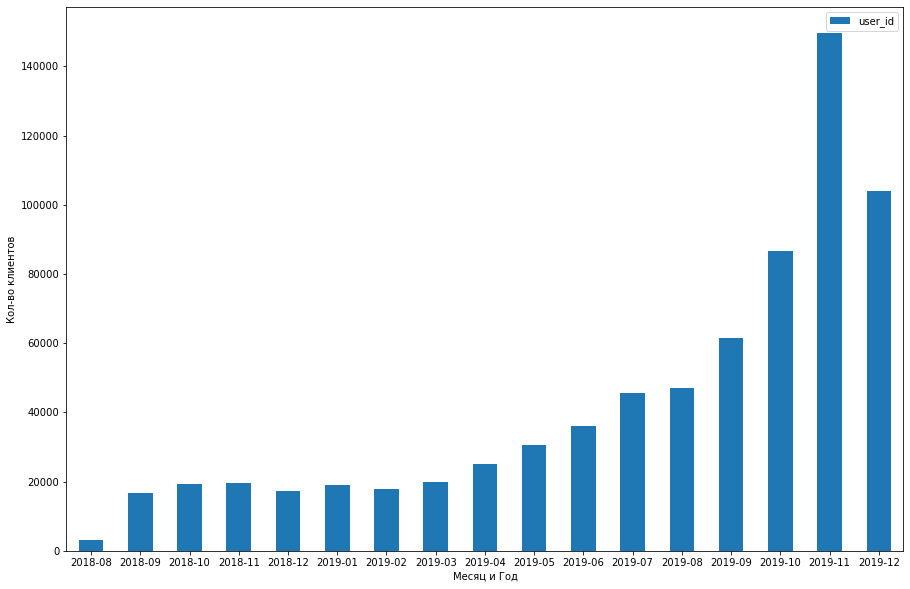

In [16]:
users_order = df_new.groupby('created_at_month_year').agg({'user_id':'count'}).reset_index()
display(users_order.tail())
fig, axs = plt.subplots(figsize=(15, 10))
print('Средний количество пользователей за весь период: ', users_order.user_id.mean(), 'клиентов')
users_order.plot(x = 'created_at_month_year', kind='bar', rot=0, ax=axs)
plt.xlabel("Месяц и Год"); 

plt.ylabel("Кол-во клиентов");

created_at_month_year  user_id
12               2019-08    30381
13               2019-09    38364
14               2019-10    55919
15               2019-11    88652
16               2019-12    71987

Средний количество уникаьных пользователей за весь период:  27533.176470588234 клиентов


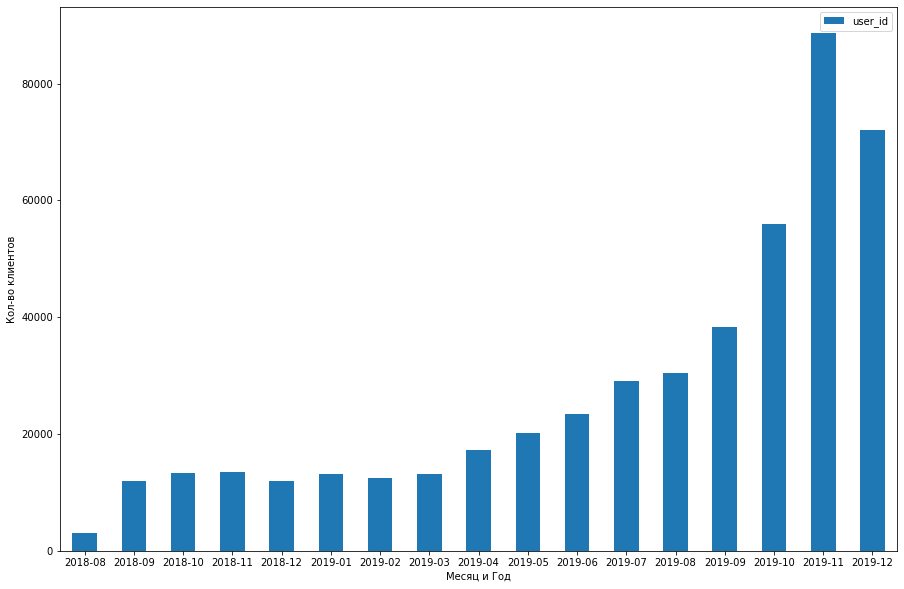

In [17]:
users_nunique = df_new.groupby('created_at_month_year').agg({'user_id':'nunique'}).reset_index()
display(users_nunique.tail())
fig, axs = plt.subplots(figsize=(15, 10))
print('Средний количество уникаьных пользователей за весь период: ', users_nunique.user_id.mean(), 'клиентов')
users_nunique.plot(x = 'created_at_month_year', kind='bar', rot=0, ax=axs)
plt.xlabel("Месяц и Год"); 

plt.ylabel("Кол-во клиентов");

    1. Построив график по количеству клиентаов за данный период, можно заметить резкий рост за ноябрь 2019-ого: у  приложения было почти в два раза больше клиентов, чем в октябрь и на треть больше, чем за декабрь. Может быть много факторов такого спроса - но, вероятнее всего, Черная пятница. 
    2. Средний количество пользователей за весь период назвать сложно, потому что показатели за разные месяцы очень разные - в среднем за весь период 42.332 человека, но учитывая, что до марта 2019-го пик наших клиентов составлят 2000 человек, то с марта по октябрь мы видим резкий рост от 20.000 тыс до 85.000 и доходит до своего пика в ноябре - 140 тыс пользователей. Вероятно, у компании была какая-то крупная рекламаная акция, которая со временем привела до 120 тыс клиентов
    3. В то же время важно анализировать уникальных клиентов - также виден рост начиная с марта 2019-го и пик в ноябре. С марта клиентская база данных выросла от 13 тыс до 88 тыс клиентов

-  Средний чек <a id="Срчек"></a> 

created_at_month_year   item_total
12               2019-08  4472.648548
13               2019-09  4466.894076
14               2019-10  4936.453387
15               2019-11  5310.106352
16               2019-12  4789.147708

Средний чек за весь период:  4711.5790160684555 рублей


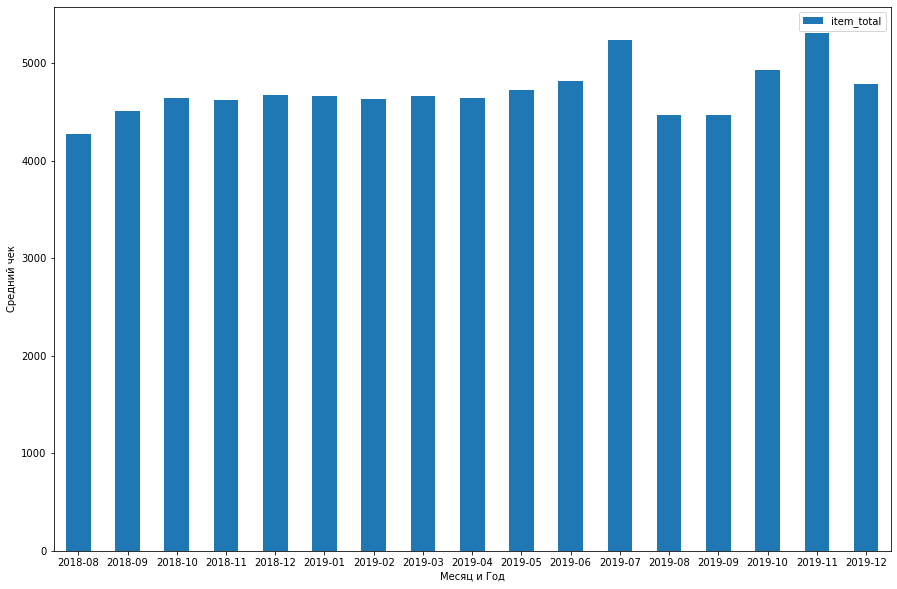

In [18]:
item_total = df_new.groupby('created_at_month_year').agg({'item_total':'mean'}).reset_index()
display(item_total.tail())
print('Средний чек за весь период: ', item_total.item_total.mean(), 'рублей')
fig, axs = plt.subplots(figsize=(15, 10))
item_total.plot(x = 'created_at_month_year', kind='bar', rot=0, ax=axs)

plt.xlabel("Месяц и Год"); 

plt.ylabel("Средний чек");

Видно, что пик и по количеству товаров наблюдается в июле и в ноябре и резкий спад в августе и сентбре - веротяно, клиенты экономят после отпуска или их дети активно питаются в школе в первый месяц учебы. Одинаковый спад заметен как в августе 2018, так и в августе 2019. Примечательно, что ноябрь не так сильно выражен в 2018, как в 2019 году, а значит, с прибавлением клиентов средний чек вырос в особенно праздничные дни. Остается загадкой резкий рост для июля, вероятно, сайт предоставлял какую-то очень выгодную сделку, но тем не менее, покупателям она очень пришлась по душе

-  Средний вес <a id="вес"></a> 

created_at_month_year  total_weight
12               2019-08  22893.564360
13               2019-09  22882.501001
14               2019-10  25129.338377
15               2019-11  24193.920379
16               2019-12  21393.948963

Средний вес товаров за весь период:  24.58409669535716 кг


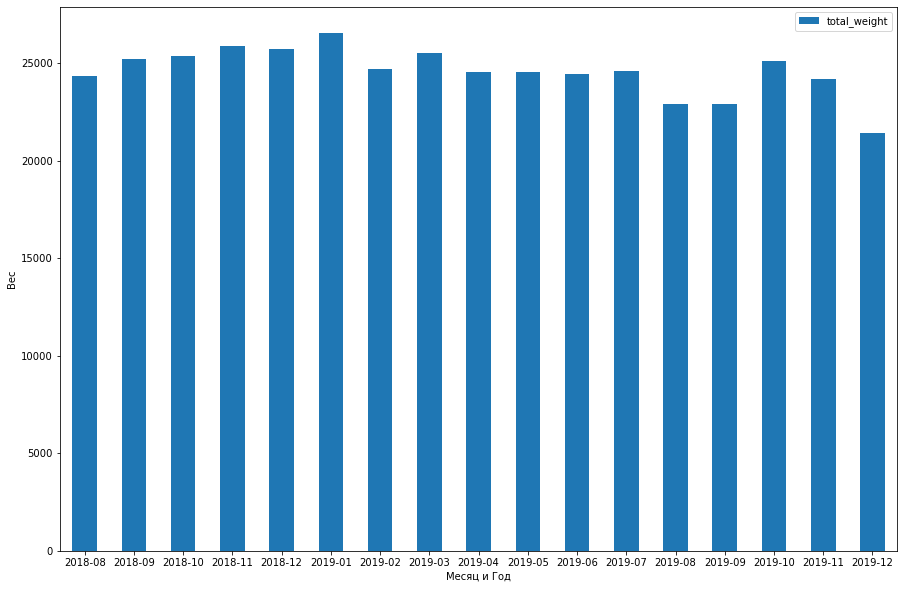

In [19]:
total_weight = df_new.groupby('created_at_month_year').agg({'total_weight':'mean'}).reset_index()
display(total_weight.tail())
print('Средний вес товаров за весь период: ', total_weight.total_weight.mean()/1000, 'кг')
fig, axs = plt.subplots(figsize=(15, 10))
total_weight.plot(x = 'created_at_month_year', kind='bar', rot=0, ax=axs)
plt.xlabel("Месяц и Год"); 

plt.ylabel("Вес");

Мы наблюдаем, что несмотря на высокий поток клиентов в ноябре, вес товаров не особо отличаются от среднего - те клиент покупает столько же товаров по весу, как обычно, но за более высокую сумму, что еще ра доказывает, что это обусловлено Черной пятницей. 
Наблюдая корреляцию за январь 2018-ого по среднему чеку и среднему весу, можно сказать, что клиенты покупают больше товаров за ту же самую цену, а значит, январьская сдлека отлично работает. Также видно резкий спад в августе и сентбре (как и по среднему чеку). Зная данную информацию, можно заказывать меньше быстропортящихся товаров на август и сентябрь, чтобы товар не пропадал от недостатка покупателей на него. 

- Среднее количество товаров  <a id="количествотоваров"></a> 

created_at_month_year  total_quantity
12               2019-08       39.473418
13               2019-09       39.839975
14               2019-10       42.399207
15               2019-11       43.032340
16               2019-12       38.862002

Среднее количество товаров за весь период:  40.828909648242174


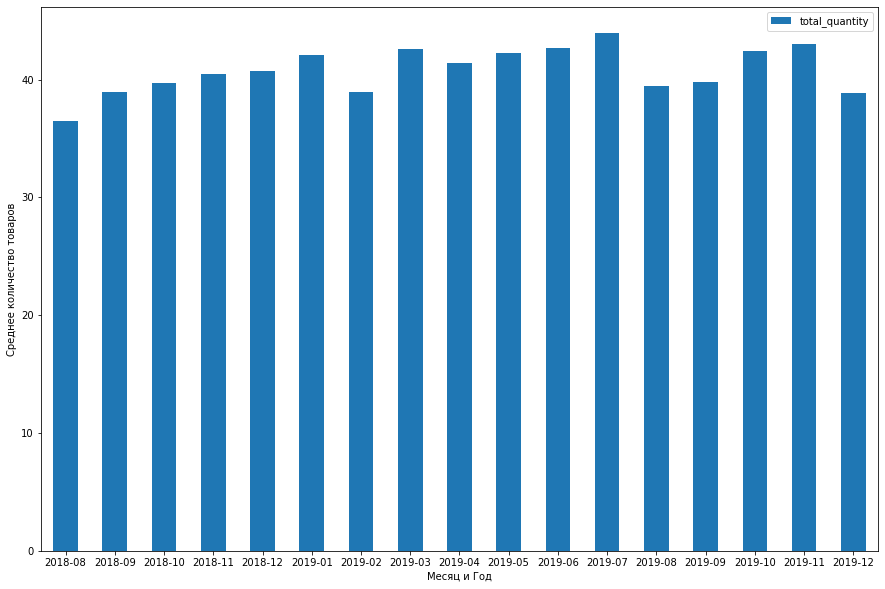

In [20]:
total_quantity = df_new.groupby('created_at_month_year').agg({'total_quantity':'mean'}).reset_index()
display(total_quantity.tail())
print('Среднее количество товаров за весь период: ', total_quantity.total_quantity.mean())
fig, axs = plt.subplots(figsize=(15, 10))
total_quantity.plot(x = 'created_at_month_year', kind='bar', rot=0, ax=axs)
plt.xlabel("Месяц и Год"); 

plt.ylabel("Среднее количество товаров");

Своего максимума по количеству товаров график достигает в точках за июль и ноябрь, и снова спад в августе и сентябре. Минимум товаров было продано за февраль 2018-ого - сложно сказать почему, учитывая, что и вес, и средний чек не вызывают вопросов остаются в норме. 

- Средняя сумма доставки  <a id="суммадоставки"></a> 

created_at_month_year  total_cost
12               2019-08  138.705299
13               2019-09  140.050521
14               2019-10  148.702084
15               2019-11  191.249915
16               2019-12  181.931241

Средняя сумма доставки за весь период:  174.598356016976 рублей


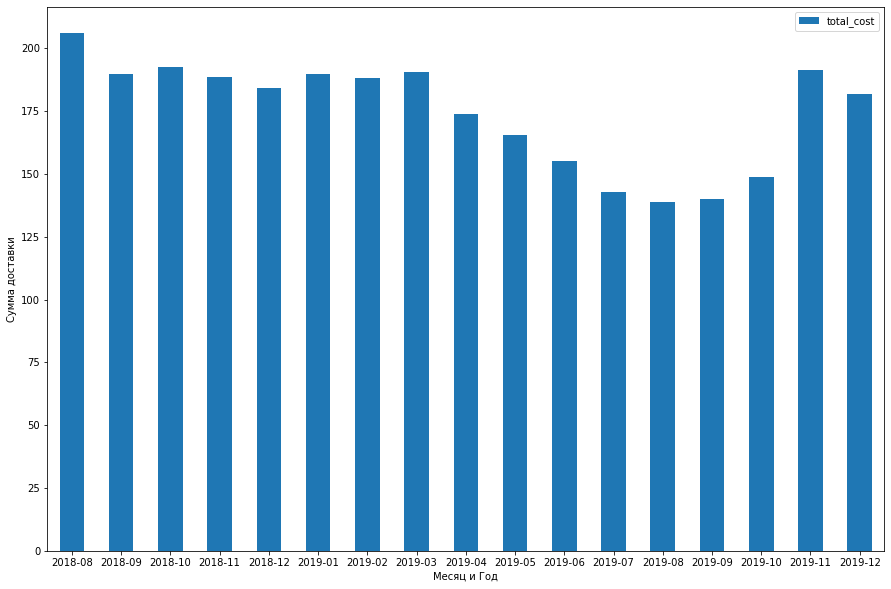

In [21]:
total_cost = df_new.groupby('created_at_month_year').agg({'total_cost':'mean'}).reset_index()
display(total_cost.tail())
print('Средняя сумма доставки за весь период: ', total_cost.total_cost.mean(), 'рублей')
fig, axs = plt.subplots(figsize=(15, 10))
total_cost.plot(x = 'created_at_month_year', kind='bar', rot=0, ax=axs)

plt.xlabel("Месяц и Год"); 

plt.ylabel("Сумма доставки");

total_cost = df_new.groupby('created_at_month_year').agg({'total_cost':'mean'}).reset_index()

- Разбор отмененных доставок <a id="отмененных"></a>

In [22]:
cancelation_pending = df[(df.state != 'shipped') & (df.state != 'ready')& (df.state != 'shipping')]
print(len(cancelation_pending))

27


In [23]:
cancelation_pending_grouped = cancelation_pending.groupby(['created_at_month_year', 'state']).agg({'user_id':'count'}).reset_index()
cancelation_pending_grouped.sort_values(by = 'user_id', ascending = False).head()

created_at_month_year     state  user_id
9                2019-11  canceled        6
7                2019-10  canceled        3
10               2019-11   pending        3
2                2018-09   pending        2
4                2018-12  canceled        2

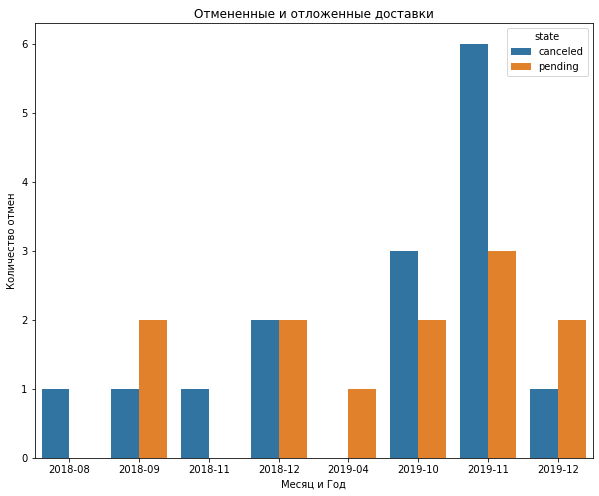

In [24]:
cancelation_pending_grouped=cancelation_pending_grouped.reset_index()
fig, axs = plt.subplots(figsize=(10, 8))


sns.barplot(x="created_at_month_year", y="user_id", data=cancelation_pending_grouped, hue = 'state');
plt.xlabel("Месяц и Год"); 
plt.ylabel("Количество отмен")
plt.title('Отмененные и отложенные доставки');

На графике видно, что больше всего отмен и задержек было выявлено за ноябрь 2019-го (можно ассоциировать с той же Черной пятницей - суммарно) и за октябрь 2018-го. Четко выражен промежуток от января до практически сентября 2019 (одна задержка за весь период) и начиная с октября задержки и отмены заказов доходят до своего пика - 6 отмен заказов и 3 задержки за один месяц. Несмотря на то, что отмен и задержек стало больше, между январем и сентябрем 2019-го наблюдается всего одна задержка, и это учитывая, что клиентов с января стало намного больше, чем было в 2018-ом. Клиентов стало в три раза больше (от 20 тыс до 60 тыс), чем было. 
Учитывая, что за ноябрь у нас было почти 150 тыс заказов, 6 отмен составляют не больше 0.01%. Тем не менее, они есть, я бы посоветовала обратить внимание на недостоюшие товары в ноябре и декабре, чтобы избежать повтора в следующем году. 

In [25]:
cancelation_pending.groupby(['store_id']).agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False).head()

user_id
store_id         
14              6
8               3
21              3
10              2
11              2

В магазине под номером 14  больше всего отмен и замен заказов - суммарно 6. Обратим на него особое внимание внимание в дальнейшем

In [26]:
cancelation_pending[cancelation_pending.store_id == 14].groupby('created_at_month_year').agg({'state':'count'})

state
created_at_month_year       
2018-09                    1
2018-11                    1
2018-12                    1
2019-11                    2
2019-12                    1

Приглядимся к номеру 14 - отмены и замены его клиентов  распростарнены по всему промежутку, очевидно, магазин плохо справляется со своими обязанностями. Из 27 случае он берет на себя 7 (22%) и значительно портит статистику в этом плане. Важно понять, в чем причины и предпринять подобающие меры для изменения ситуации.

##  Разбор таблицы replacements <a id="replacements"></a> 

- Среднее количество замен  <a id="замен"></a> 

In [27]:
pd.read_sql_query('''SELECT * FROM replacements LIMIT 5''', conn)
#Изначальньо я работала в sql и не в пандас, но решила оставить код как он есть для данного отрезка

order_id  item_id     state
0    480785  6466916  replaced
1    480785  6466940  replaced
2    480785  6466778  replaced
3    480785  6466825  replaced
4    480786  7261201  replaced

In [28]:
pd.read_sql_query('''SELECT COUNT(DISTINCT item_id)/COUNT(DISTINCT order_id) as replace_mean  FROM replacements LIMIT 10''', conn)
#Обратим внимание, сколько у нас в среднем происходит замен на один заказ, а так же макс кол-во замен

replace_mean
0             2

In [29]:
items_replaced = pd.read_sql_query('''SELECT order_id, state, COUNT(item_id) as items_replace_count FROM replacements GROUP BY order_id, state ORDER BY COUNT(item_id) DESC ''', conn)
items_replaced.head()

order_id     state  items_replace_count
0   4155539  replaced                   42
1   4727652  replaced                   41
2   3045592  replaced                   40
3   4581269  replaced                   39
4   4825590  replaced                   33

In [30]:
items_replaced.describe(percentiles = [.75, .95, .99])

order_id  items_replace_count
count  4.491650e+05        449165.000000
mean   2.861446e+06             2.783485
std    1.547668e+06             2.295636
min    4.803750e+05             1.000000
50%    2.763803e+06             2.000000
75%    4.335016e+06             4.000000
95%    5.211216e+06             7.000000
99%    5.379535e+06            11.000000
max    5.444744e+06            42.000000

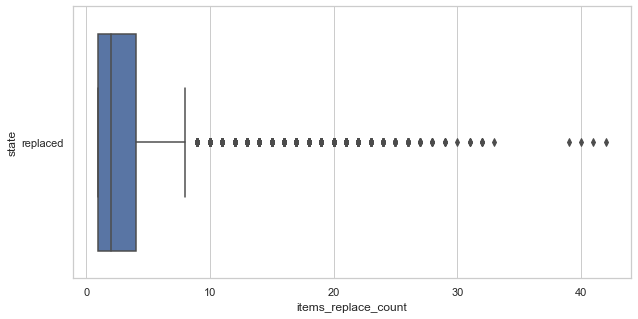

In [31]:
sns.set_theme(style="whitegrid")
a4_dims = (10, 5)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(x = 'items_replace_count', y = 'state', data = items_replaced);

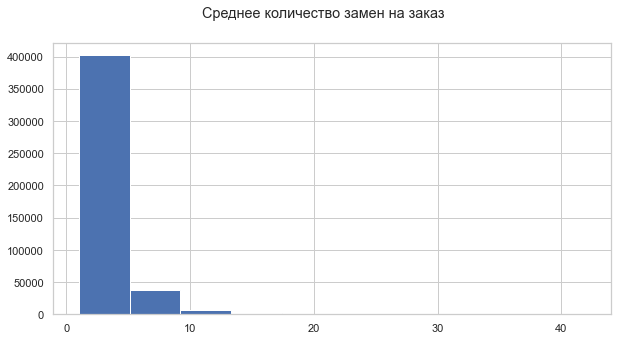

In [32]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
items_replaced.items_replace_count.hist(ax = ax)
pl.suptitle("Среднее количество замен на заказ");

В среднем у нас производится две замены на заказ, но в топ-10 замен, видно, что бывает и по 30, и по 40 замен на один заказ. Посмотрев на соотношене, видим, что у меньше, чем 25% процентов пользователей происзводится больше 4-ех замен и для всего 5% пользователей производится больше 7-ти замен на один заказ, для всего 1% производится болше 11-ти замен. Это означает, что наши 30 и 40+ замен - составляет меньше одного процента для всех клиентов.Учитывая, что в среднем у нас 42 товара на клиента, замены относятся скорее всего к тем клиентам, которые выходят за 99,9% покупателей в нашем фрейме.

##  Разбор таблицы cancellations <a id="cancellations"></a> 

- Среднее количество отмен  <a id="отмен"></a> 

In [33]:
cancellations = pd.read_sql_query('''SELECT * FROM cancellations''', conn)
cancellations.head(1)

order_id  item_id     state
0    480443  5333890  canceled

In [34]:
cancellations_grouped = cancellations.groupby('order_id').agg({'item_id': 'count'}).sort_values(by = 'item_id', ascending = False).reset_index()
cancellations_grouped.head()

order_id  item_id
0   2842837      118
1   2778719       97
2   2840178       95
3   2828961       88
4   2829861       86

In [35]:
cancellations_grouped.describe(percentiles = [.75, .95, .99])

order_id        item_id
count  4.939950e+05  493995.000000
mean   2.633006e+06       2.918258
std    1.535794e+06       2.759173
min    4.803330e+05       1.000000
50%    2.386390e+06       2.000000
75%    4.089563e+06       4.000000
95%    5.164394e+06       8.000000
99%    5.363204e+06      13.000000
max    5.443796e+06     118.000000

Как и в таблице замен - аномалия. Меньше 1% отменяли больше, чем 13 товаров за один заказ, и токльо 1% отменил до 118. Также учитывая, что в среднем у нас приходится 42 товара на человека - отмена 118 товаров что-то из ряда вон выходящее и относится к покупателям, котрые заказли в три раза больше товаров, чем типичный покупатель. 95% пользователей отменили не больше 8 товаров за один заказ. В среднем клиент отменяет от 2 до 3 товаров.

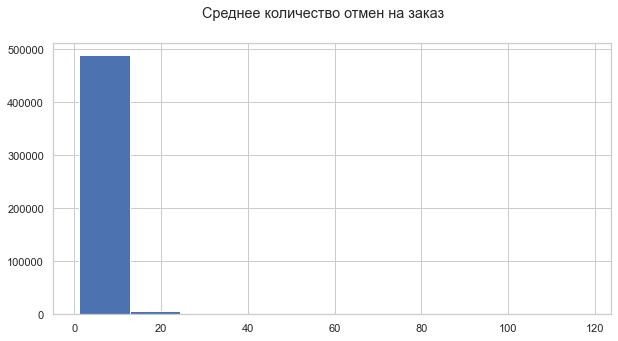

In [36]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
cancellations_grouped.item_id.hist(ax = ax)
pl.suptitle("Среднее количество отмен на заказ");

Также видно на графике - преимущественно большинство отменяет до 10-ти заказов

##  Разбор таблицы delivery_windows <a id="delivery_windows"></a> 

- время ожидания доставки <a id="ожидания"></a> 

In [37]:
delivery_windows = pd.read_sql_query('''SELECT * FROM delivery_windows ''', conn)
delivery_windows['delivery_time'] = delivery_windows.ends_at - delivery_windows.starts_at
delivery_windows.head()

store_id      id           starts_at             ends_at      time_zone  \
0         1  226459 2018-08-26 14:00:00 2018-08-26 16:00:00  Europe/Moscow   
1         1  226460 2018-08-26 15:00:00 2018-08-26 17:00:00  Europe/Moscow   
2         1  226462 2018-08-26 17:00:00 2018-08-26 19:00:00  Europe/Moscow   
3         1  226458 2018-08-26 13:00:00 2018-08-26 15:00:00  Europe/Moscow   
4         1  227250 2018-08-27 15:00:00 2018-08-27 17:00:00  Europe/Moscow   

    delivery_time  
0 0 days 02:00:00  
1 0 days 02:00:00  
2 0 days 02:00:00  
3 0 days 02:00:00  
4 0 days 02:00:00

In [38]:
delivery_windows.delivery_time.value_counts()

c = delivery_windows.delivery_time.value_counts(dropna=False)
p = (delivery_windows.delivery_time.value_counts(dropna=False, normalize=True)*100).round(2)
pd.concat([c,p], axis=1, keys=['counts', '%']).head()

counts      %
0 days 02:00:00  184902  90.49
0 days 03:00:00    4608   2.26
0 days 01:00:00    3990   1.95
0 days 08:00:00    3273   1.60
0 days 04:00:00    2858   1.40

In [39]:
delivery_windows_grouped = delivery_windows.groupby(['delivery_time']).agg({'id':'count'}).reset_index()
display(delivery_windows_grouped.describe(percentiles = [.75, .95, .99]))

delivery_time             id
count                         12      12.000000
mean             0 days 04:47:30   17028.583333
std    0 days 03:41:21.874183193   52892.291238
min              0 days 00:00:00       2.000000
50%              0 days 04:30:00    1755.000000
75%              0 days 07:15:00    3452.250000
95%              0 days 10:27:00   85740.300000
99%              0 days 10:53:24  165069.660000
max              0 days 11:00:00  184902.000000

delivery_time      id
0 0 days 00:00:00       2
1 0 days 00:30:00    2626
2 0 days 01:00:00    3990
3 0 days 02:00:00  184902
4 0 days 03:00:00    4608

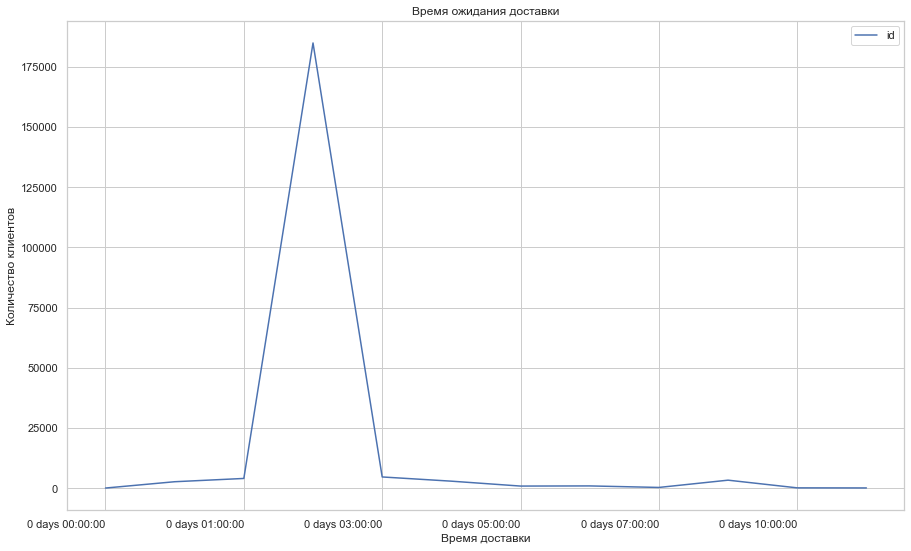

In [40]:
display(delivery_windows_grouped.head())
fig, axs = plt.subplots(figsize=(15, 10))
delivery_windows_grouped.plot(x = 'delivery_time', rot=0, ax=axs)

plt.title('Время ожидания доставки')
plt.xlabel("Время доставки"); 

plt.ylabel("Количество клиентов");

В среднем клиент получает свой заказ в течение 4 с половиной часов с начала доставки, но есть и такие, кто ждали больше 7-ми часов (25% клиентов), 5% коиентов ждали больше 10 с полвиной часов, и 1% ждал больше 10-ти часов и 53-ех минут. Максимум клиенты ждали 11 часов (45 клиентов - 0.02%). 
В 90% случаев клиент ждет 2 часа и лишь в 2% - 3 часа. Время одидания до двух часов или больше 3-ех часов составляет меньше 2% для каждого отдельного часа. Время ожидания больше 5-ти часов - меньше полцпроцента для каждого отдельного часа.

In [41]:
delivery_windows[delivery_windows['delivery_time'] > '0 days 10:00:00'].store_id.unique()
#номера магазинов, клиенты которых ждали больше 10-ти часов.

array([62, 63])

In [42]:
display(delivery_windows[delivery_windows['store_id'] == 62].groupby('store_id').agg({'delivery_time':'count'}))
delivery_windows[delivery_windows['store_id'] == 63].groupby('store_id').agg({'delivery_time':'count'})
#Посмотрим, сколько всего заказов выполнили магазины под номерами 62 и 63, это пригодится в дальнейшем

delivery_time
store_id               
62                 5416

delivery_time
store_id               
63                 4622

In [43]:
delivery_windows_over = delivery_windows[delivery_windows['delivery_time'] > '0 days 10:00:00'].groupby('store_id').agg({'delivery_time':'count'}).reset_index()
delivery_windows_over

store_id  delivery_time
0        62             11
1        63             34

Мы уже встречали до этого магазин под нмоером 63 - один из его клиентов нахоится в списке ожижания pending. Тем не менее, это уже аномалия, что всего два магазина так сильно порятят статистику и 45 только их клиентов ждали доставку еды более 10-ти часов. Магазины под номерами 62 и 63 берут на себя 36% от всех задержек на 10+ часов для всего спсика,

# Вывод <a id="вывод"></a> 

In [44]:
print('Средняя сумма доставки за весь период: ', int(total_cost.total_cost.mean()), 'рублей')
print('Средний количество пользователей за весь период: ', int(users_order.user_id.mean()), 'человека')
print('Средний количество уникаьных пользователей за весь период: ', int(users_nunique.user_id.mean()), 'клиентов')
print('Средний вес товаров за весь период: ', int(total_weight.total_weight.mean()/1000), 'кг')
print('Среднее количество товаров за весь период: ', int(total_quantity.total_quantity.mean()), 'товаров')
print('Средний чек за весь период: ', int(item_total.item_total.mean()), 'рублей')

Средняя сумма доставки за весь период:  174 рублей
Средний количество пользователей за весь период:  42294 человека
Средний количество уникаьных пользователей за весь период:  27533 клиентов
Средний вес товаров за весь период:  24 кг
Среднее количество товаров за весь период:  40 товаров
Средний чек за весь период:  4711 рублей


Изучив данные срезов, мы нашли разного рода аномалии и изучили их. После чего почистили фрейм от данных аномаий и сделали исследование средних значений. Выделили характеристики среднего покупателя по месяцам. Разберем по порядку, что было обнаружено: 

- сумма доставки
    1. Графы total_cost и cost значения сильно похожи, но следует заметить, что минимальное начение для total_cost уходит в минус - значит, кто-то "заработал" на скидке. Максимум для них обоих - 30.000 рублей за доставку (что характерно только для 1%, для 99% характерны доставки суммой до 700 рублей).
    2. Некотрые клиенты (три случая) "заработали" на скидке - их финальная стоимость доставки выходит ниже нуля. Это может быть связано с ошибкой в системе.
    3. Средняя сумма доставки составляет 176 рублей.
- количество товара на одного покупателя
    1. Графа total_quantity(Количество единиц товара) варьирует в среднем до 200 товаров для 99% покупателей. Только для 1% характерно покупать на свыше, чем 200 товаров и доходит до своего максимума в 36 тыс единиц товара, купленного за раз.
    2. Я выделила отдельную группу тех клиентов, которые больше всего заказывают товаров (а именно таких товаров, которых по количеству заказывает только 0.1% клиентов) и обнаружила, что один из клиентов встречается 92 раза в списке, сделав закз в среднем на 1117 единиц товара. Есть клиент, который также встречается в списке 41 раз и делает покупки на в среднем 1123 единицы товара. Также нам попадает клиент, которые единожды сделал заказ на максимальное число товров - 36040 единиц весом в 20 кг. Примечательно, что это его единичное появление на сайте в целом, и его покупка составила 25.7 тыс рублей. Поскольку заказ отправлен и не отменен, сложно назвать данную аномалию ошибкой, но сами ее истоки мне вычеслить не удалось. В дальнейшем я исключила 0.1% для вычисления среднего количества заказов
    3. Среднее количество товаров за весь период составило  41 товар на каждого покупателя
- средний чек 
    1. Графа item_total(средний чек)также имеет аномалии - для 90% харктерен средний чек на 8750 рублей и меньше, для оставшихся 10% - почти 20 тыс рублей и для 1% - от 20 тыс рублей до 481.195 тыс рублей (почти полмиллиона рублей).
    2. Видим, что один из клиентов в списке из 156 человек с самым высоким средним чеком находится 23 раза (14% от всей группы) со средним чеком в 125 тыс рублей, другой клиент (мы уже встречали его ранее) встретился нам 17 раз и купил товара на 107 тыс рублей в среднем - те есть клиенты, которые в среднем покупают на большие суммы, но многиеих них встречаются не больше одного раза в списке дорогих закупок. Тем не менее, явление все еще достаточно редкое и я включю его скорее в рзряд "исключений", нежели повсеместной практики.
    3. В графе "средний чек" данные разбросаны намного сильнее, чем в других строках - но все еще не свыше 30-и человек заказали на больше, чем 200 тыс рублей, большинство колеблется на сумме до 100 тысяч. В дальнейшем я включу в "чистую" таблицу только тех покупателей, которые заказывают товары на сумму до 100 тысяч рублей
    4. Средний чек сосавтялет  4732 рублей.
- средний вес
    1. Мы наблюдаем, что несмотря на высокий поток клиентов в ноябре, вес товаров не особо отличаются от среднего - те клиент покупает столько же товаров по весу, как обычно, но за более высокую сумму, что еще раз доказывает, что это обусловлено Черной пятницей. Наблюдая корреляцию за январь 2018-ого по среднему чеку и среднему весу, можно сказать, что клиенты покупают больше товаров за ту же самую цену (веротяно, распродажа товаров на Новый год, которые не были проданы к сроку). Также видно резкий спад в августе и сентбре (как и по среднему чеку). Зная данную информацию, можно заказывать меньше быстропортящихся товаров на август и сентябрь, чтобы товар не пропадал от недостатка покупателей на него.
    2. Средний вес товаров за весь период сосавтялет 24 кг
- Среднее количествo покупателей 
    1. Построив график по количеству клиентаов за данный период, можно заметить резкий рост за ноябрь 2019-ого: у  приложения было почти в два раза больше клиентов, чем в октябрь и на треть больше, чем за декабрь. Может быть много факторов такого спроса - но, вероятнее всего, Черная пятница. 
    2. Средний количество пользователей за весь период назвать сложно, потому что показатели за разные месяцы очень разные - в среднем за весь период 42.332 человека, но учитывая, что до марта 2019-го пик наших клиентов составлят 2000 человек, то с марта по октябрь мы видим резкий рост от 20.000 тыс до 85.000 и доходит до своего пика в ноябре - 140 тыс пользователей. Вероятно, у компании была какая-то крупная рекламаная акция, которая со временем привела до 120 тыс клиентов
    3. В то же время важно анализировать уникальных клиентов - также виден рост начиная с марта 2019-го и пик в ноябре. С марта клиентская база данных выросла от 13 тыс до 88 тыс клиентов и в средем у нас 27533 уникаьных пользователей за весь период.  
- Отмененные и отложенные доставки
    1. На графике видно, что больше всего отмен и задержек было выявлено за ноябрь 2019-го (можно ассоциировать с той же Черной пятницей - суммарно) и за октябрь 2018-го. Четко выражен промежуток от января до практически сентября 2019 (одна задержка за весь период) и начиная с октября задержки и отмены заказов доходят до своего пика - 6 отмен заказов и 3 задержки за один месяц. Несмотря на то, что отмен и задержек стало больше, между январем и сентябрем 2019-го наблюдается всего одна задержка, и это учитывая, что клиентов с января стало намного больше, чем было в 2018-ом. Клиентов стало в три раза больше (от 20 тыс до 60 тыс), чем было. 
    2. Учитывая, что за ноябрь у нас было почти 150 тыс заказов, 6 отмен составляют не больше 0.01%. Тем не менее, они есть, я бы посоветовала обратить внимание на недостоюшие товары в ноябре, чтобы избежать повтора в следующем году. Также неудивительно, что у нас практически не было 
    3. Приглядимся к номеру 14 - отмены и замены его клиентов  распростарнены по всему промежутку, очевидно, магазин плохо справляется со своими обязанностями. Из 27 случае он берет на себя 7 (22%) и значительно портит статистику в этом плане. Важно понять, в чем причины и предпринять подобающие меры для изменения ситуации.
- замены
    1. В среднем у нас производится две замены на заказ, но в топ-10 замен, видно, что бывает и по 30, и по 40 замен на один заказ. Посмотрев на соотношене, видим, что у меньше, чем 25% процентов пользователей происзводится больше 4-ех замен и для всего 5% пользователей производится больше 7-ти замен на один заказ, для всего 1% производится болше 11-ти замен. Это означает, что наши 30 и 40+ замен - составляет меньше одного процента для всех клиентов.Учитывая, что в среднем у нас 42 товара на клиента, замены относятся скорее всего к тем клиентам, которые выходят за 99,9% покупателей в нашем фрейме.
- отмены
    1. Как и в таблице замен - аномалия. Меньше 1% отменяли больше, чем 13 товаров за один заказ, и токльо 1% отменил до 118. Также учитывая, что в среднем у нас приходится 42 товара на человека - отмена 118 товаров что-то из ряда вон выходящее и относится к покупателям, котрые заказли в три раза больше товаров, чем типичный покупатель. 95% пользователей отменили не больше 8 товаров за один заказ. В среднем клиент отменяет от 2 до 3 товаров.
- время доставки
    1. В среднем клиент получает свой заказ в течение 4 с половиной часов с начала доставки, но есть и такие, кто ждали больше 7-ми часов (25% клиентов), 5% коиентов ждали больше 10 с полвиной часов, и 1% ждал больше 10-ти часов и 53-ех минут. Максимум клиенты ждали 11 часов (45 клиентов - 0.02%). В 90% случаев клиент ждет 2 часа и лишь в 2% - 3 часа. Время одидания до двух часов или больше 3-ех часов составляет меньше 2% для каждого отдельного часа. Время ожидания больше 5-ти часов - меньше полцпроцента для каждого отдельного часа.

# Рекомендации

Я бы посоветовала приглядеться к магазинам под номерами 14, 62 и 63. Номер 14 лидирует по отменам и задержкам и значительно портит статистику (берет на себя 22% от всех отмен и задержек заказов). Номера 62 и 63  вместе берут на себя 36% от всех задержек на 10 и более часов ожидания и также значительно портят статистику (45 только их клиентов ждали доставку еды более 10-ти часов.). 

Я бы также посоветовала проявить больше внимания к концу года, а именно к ноябрю - мы видим колосальный прирост клиентов в особенности в этом месяце по причине, вероятно, Черной пятницы. Количество как уникальных пользователей, так и повторяющихся достигает своего максимума именно в ноябре и сайт "проседает" на отменах и заменах также в особенности в ноябре. 

* [Метрики](#метрики)
* [Разбор аномалий и закономерностей](#аномалий)
   * [Разбор таблицы orders](#orders)
       * [Разбор аномалий по сумме доставки](#доставки)
       * [Разбор аномалий по колиечству товара](#количество)
       * [Разбор аномалий по  среднему чеку](#чеку)
       * [Чистка данных](#Чистка)
       * [Среднее количествo покупателей](#покупателей) 
       * [Средний чек](#Срчек) 
       * [Средний вес](#вес)
       * [Среднее количество товаров](#количествотоваров)
       * [Средняя сумма доставки](#суммадоставки)
       * [Разбор отмененных доставок](#отмененных)
   * [Разбор таблицы replacements](#replacements)
       * [Среднее количество замен](#замен) 
   * [Разбор таблицы cancellations](#cancellations)
       * [Среднее количество отмен](#отмен) 
   * [Разбор таблицы delivery_windows](#delivery_windows)
       * [Время одидания доставки](#ожидания) 
* [Вывод](#вывод) 